Pewnego wieczoru w malowicznym Zakopanem - stolicy ówczesnego świata artystycznego Młodej Polski - spotkali się Kazimierz Przerwa-Tetmajer oraz Henryk Sienkiewicz: 

    - Kazimierz Przerwa-Tetmajer, kłaniam się - powiedział poeta. 
    - Miło mi. Henryk *bez przerwy* Sienkiewicz - odpowiedział powieściopisarz.

***

In [48]:
from string import punctuation, digits
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import altair as alt
import pandas as pd
import re
from itertools import chain

## Cel zadania

W poniższej pracy skupię się na utworzeniu reprezentacji word2vec dla słów wchodzących w skład korpusu utworzonego na bazie twórczości <s>Henryka Sienkiewicza</s> polskich pozytywistów.

## Dane tekstowe

Do dyspozycji mam następujące utwory, z których każdy zapisany jest w oddzielnym pliku tekstowym. Korpus zostanie utworzony z powieści, opowiadań i nowelek:

In [171]:
!ls ./data/henryk_sienkiewicz/

bartek-zwyciezca.txt
bez-dogmatu.txt
janko-muzykant.txt
krzyzacy.txt
latarnik.txt
list-otwarty-polaka-do-ministra-rosyjskiego.txt
na-jasnym-brzegu.txt
na-marne.txt
na-oceanie-atlantyckim.txt
na-polu-chwaly.txt
niewola-tatarska.txt
ogniem-i-mieczem.txt
pan-wolodyjowski.txt
potop.txt
quo-vadis.txt
rodzina-polanieckich.txt
sienkiewicz-badz-blogoslawiona.txt
sienkiewicz-bajka.txt
sienkiewicz-co-sie-raz-stalo-w-sydonie.txt
sienkiewicz-czy-ci-najmilszy.txt
sienkiewicz-diokles.txt
sienkiewicz-dwie-laki.txt
sienkiewicz-hkt.txt
sienkiewicz-jako-sie-pan-lubomirski-nawrocil.txt
sienkiewicz-legenda-zeglarska.txt
sienkiewicz-na-olimpie.txt
sienkiewicz-orso.txt
sienkiewicz-plomyk.txt
sienkiewicz-pojdzmy-za-nim.txt
sienkiewicz-przygoda-arystoklesa.txt
sienkiewicz-sabalowa-bajka.txt
sienkiewicz-sachem.txt
sienkiewicz-sad-ozyrysa.txt
sienkiewicz-toast.txt
sienkiewicz-u-bramy-raju.txt
sienkiewicz-we-mgle.txt
sienkiewicz-wesele.txt
sienkiewicz-wspomnienie-z-maripozy.txt
sienkiewicz-wyrok-zeusa.txt
sienki

W folderze z danymi znajduje się następująca liczba plików:

In [172]:
! find ./data/henryk_sienkiewicz/ -maxdepth 1 -type f -name "*.txt" -printf x | wc -c 

46


które ważą łącznie:

In [173]:
! du -sbh ./data/henryk_sienkiewicz/

16M	./data/henryk_sienkiewicz/


Wiekszość plików została pobrana ze strony [Wolne Lektury](https://wolnelektury.pl/), kilka natomiast z [Wikiźródła](https://pl.wikisource.org/wiki/Wiki%C5%BAr%C3%B3d%C5%82a:Strona_g%C5%82%C3%B3wna).

## Czyszczenie danych

Książki pobrane z Wolnych Lektur są opatrzone komentarzem na początku pliku. Konieczne jest usunięcie numeru ISBN:

In [37]:
! head ./data/raw_examples/sienkiewicz-bajka.txt -n 10

Henryk Sienkiewicz

Bajka

ISBN 978-83-288-2802-5


Za górami, za morzami, w dalekiej krainie czarów, przy kolebce małej księżniczki zebrały się dobre wróżki ze swą królową na czele.

I gdy otoczywszy księżniczkę patrzyły na uśpioną twarzyczkę dzieciny, królowa ich rzekła:


Na końcu pliku znajduje się komentarz, który także podlega usunięciu:

In [38]:
! tail ./data/raw_examples/sienkiewicz-bajka.txt -n 25


To rzekłszy królowa wróżek pochyliła się nad śpiącą dzieciną i dotknąwszy rękami jej serca rzekła:

— Bądź dobrą!




-----
Ta lektura, podobnie jak tysiące innych, dostępna jest na stronie wolnelektury.pl.
Wersja lektury w opracowaniu merytorycznym i krytycznym (przypisy i motywy) dostępna jest na stronie http://wolnelektury.pl/katalog/lektura/sienkiewicz-bajka.

Utwór opracowany został w ramach projektu Wolne Lektury przez fundację Nowoczesna Polska.

Ten utwór nie jest objęty majątkowym prawem autorskim i znajduje się w domenie publicznej, co oznacza że możesz go swobodnie wykorzystywać, publikować i rozpowszechniać. Jeśli utwór opatrzony jest dodatkowymi materiałami (przypisy, motywy literackie etc.), które podlegają prawu autorskiemu, to te dodatkowe materiały udostępnione są na licencji Creative Commons Uznanie Autorstwa – Na Tych Samych Warunkach 3.0 PL (http://creativecommons.org/licenses/by-sa/3.0/).

Tekst opracowany na podstawie: Henryk Sienkiewicz, Baśnie i legendy, wybór,

Pliki pobrane z Wikiźródeł także opatrzone są zbędnymi w analizie komentarzami. Informacja dotyczy na przykład faktu pobrania pliku z Wikiźródeł:

In [41]:
! grep -rnw ./data/henryk_sienkiewicz// -e 'Wikiźródeł'

./data/henryk_sienkiewicz/na-polu-chwaly.txt:6036:W publikacji została zachowana oryginalna ortografia, oczywiste błędy w druku zostały poprawione przez redaktorów Wikiźródeł.
./data/henryk_sienkiewicz/Wiry.txt:6137:W publikacji została zachowana oryginalna ortografia, oczywiste błędy w druku zostały poprawione przez redaktorów Wikiźródeł.


Informacje zbędne znajdują się na początku i na końcu plików. Automatycznie (i bezpiecznie) można usunąć linie zawierające słowa *ISBN*, *Wolne lektury*, *wolnelektury*, *Wikiźródła*, *Creative Commons*, *Opracowanie redakcyjne*. Używam poniższego skryptu. Usuwam wszystkie kolejne linie po wystąpieniu *-----* lub *Wesprzyj Wolne Lektury*:

In [42]:
! cat ./scripts/delete_text.sh

#!/bin/bash
for filename in *.txt; do
	sed -i.bak '/creativecommons\|ISBN\|wolnelektury\|Wolne Lektury\|*Wikiźród*\|Creative Commons\|http/d' $filename
	sed -i.bak '/-----/,+100 d' $filename
	sed -i.bak '/Wesprzyj Wolne Lektury/,+100 d' $filename
done



Reszta niepotrzebnego tekstu została usunięta ręcznie.

## Czyszczenie tekstu

Po uzyskaniu właściwego tekstu utworów Sienkiewicza mogę przejść do czyszczenia zawartości plików ze znaków interpunkcyjnych i cyfr oraz zamianę wielkich liter na małe:

In [44]:
def load_file(file):
    # file in read-only mode
    with open(file, 'r') as file:
        # text is list of lines
        text = file.readlines()
    return text

W plikach przekonwertowanych z `.mobi` do `.txt` mamy znaki, które bez odpowiedniego przetworzenia dyskwalfikują słowa z dalszej analizy. `\xad` to oznaczenie miękkiego podziału słowa (ang. *soft hyphen*), który informuje, w którym miejscu słowo może zostać podzielone, jeżeli wstawienie całego słowa do linijki powoduje przekroczenie limitu znaków w tej linijce.

In [45]:
invalid_line = load_file("./data/pozytywizm/prus/faraon.txt")[241]
invalid_line

'Ro\xaddo\xadwi\xadci Egip\xadcja\xadnie mie\xadli bar\xadwę skó\xadry mie\xaddzia\xadną7, czym cheł\xadpi\xadli się, gar\xaddząc jed\xadno\xadcze\xadśnie czar\xadny\xadmi Etio\xadpa\xadmi, żół\xadty\xadmi Se\xadmi\xadta\xadmi i bia\xadły\xadmi Eu\xadro\xadpej\xadczy\xadka\xadmi. Ten ko\xadlor skó\xadry, po\xadzwa\xadla\xadją\xadcy od\xadróż\xadnić swo\xadje\xadgo od ob\xadce\xadgo, przy\xadczy\xadniał się do utrzy\xadma\xadnia na\xadro\xaddo\xadwej jed\xadno\xadści sil\xadniej ani\xadże\xadli re\xadli\xadgia, któ\xadrą moż\xadna przy\xadjąć, al\xadbo ję\xadzyk, któ\xadre\xadgo moż\xadna się wy\xaduczyć.\n'

In [46]:
invalid_line.replace("\xad", "")

'Rodowici Egipcjanie mieli barwę skóry miedzianą7, czym chełpili się, gardząc jednocześnie czarnymi Etiopami, żółtymi Semitami i białymi Europejczykami. Ten kolor skóry, pozwalający odróżnić swojego od obcego, przyczyniał się do utrzymania narodowej jedności silniej aniżeli religia, którą można przyjąć, albo język, którego można się wyuczyć.\n'

Pojawia się kolejny problem: słowa z przypisami (np. *miedzianą7*) muszą być oczyszczane z liczb.

In [49]:
word_w_footnote = 'miedzianą7'
word_w_footnote.rstrip(digits)

'miedzianą'

In [50]:
def clean_line(line):
    # delete trailing \n
    line = line.rstrip()
    # get tokens
    tokens = line.split()
    # remove punctuation
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove soft hyphens
    tokens = [w.replace("\xad", "") for w in tokens]
    # remove footnote refs
    tokens = [w.rstrip(digits) for w in tokens]
    # leave only letters
    tokens = [word for word in tokens if word.isalpha()]
    # no capital letters
    tokens = [word.lower() for word in tokens]
    return tokens

In [51]:
vocabulary_count = Counter()

for filename in os.listdir('./data/henryk_sienkiewicz/'):
    for text_line in load_file(os.path.join('./data/henryk_sienkiewicz/', filename)):
        if text_line == "\n":
            continue
        clean_tokens = clean_line(text_line)
        vocabulary_count.update(clean_tokens)

Okazuje się, że korpus oparty jedynie o twórczość Henryka Sienkiewicza ma tylko ponad 2 mln słów:

In [52]:
sum(vocabulary_count.values())

2060450

## Dodatkowe dane tekstowe

Konieczne jest dodanie innych autorów. Dodaję utwory autorów epoki pozytywizmu (w której duchu z resztą tworzył Sienkiewicz): Stefan Żeromski, Bolesław Prus, Władysław Reymont, Eliza Orzeszkowa, Maria Konopnicka oraz Michał Bałucki. Liczba nowych plików, które dochodzą to:

In [53]:
! find ./data/pozytywizm/ -type f -name "*.txt" -printf x | wc -c 

125


In [54]:
! du -sbh ./data/pozytywizm/

33M	./data/pozytywizm/


Pliki czyszczę nowym skryptem, który na podstawie prób i błędów rozszerzył funkcjonalność poprzedniego:

In [55]:
! cat ./data/maly_skrypt.sh

#!/bin/bash
for filename in $(find ./pozytywizm -name '*.txt'); do
	sed -i '/creativecommons\|ISBN\|wolnelektury\|Wolne Lektury\|*Wikiźród*\|Creative Commons\|http\|Jak możesz pomóc\?\|Co roku do domeny publicznej przechodzi/d' $filename
	sed -i '/-----/,$d' $filename
	sed -i '/Wesprzyj Wolne Lektury!/,$d' $filename
	sed -i '/Przekaż 1% podatku na rozwój Wolnych Lektur:/,$d' $filename
done


Dla nowych plików tekstowych powtarzam kroki wykonane dla plików zawierających twórczość Henryka Sienkiewicza:

In [56]:
for author_dir, _, _ in os.walk("./data/pozytywizm/"):
    if author_dir == './data/pozytywizm/':
        continue
    for file in os.listdir(author_dir):
        for text_line in load_file(os.path.join(author_dir, file)):
            if text_line == "\n":
                continue
            clean_tokens = clean_line(text_line)
            vocabulary_count.update(clean_tokens)

Po wprowadzeniu utworów innych autorów z epoki pozytywizmu uzyskałem korpus liczący więcej niż 5,8 mln słów:

In [57]:
sum(vocabulary_count.values())

5876081

## Statystyki korpusu

10 najczęściej występujących słów w korpusie to spójniki i partykuły:

In [58]:
vocabulary_count.most_common(10)

[('i', 214558),
 ('się', 150620),
 ('w', 135190),
 ('nie', 106474),
 ('na', 105147),
 ('z', 101554),
 ('do', 65563),
 ('a', 63111),
 ('to', 62638),
 ('że', 59799)]

Następująca liczba unikalnych słów znajduje się w korpusie:

In [59]:
len(list(vocabulary_count.keys()))

262178

Ze względu na bogatą morfologię języka polskiego rzeczywiste użycie danego słowa jest w pewnym sensie niedoszacowane. Załóżmy, że chcemy stwierdzić czy dany tekst dotyczy *kota*. Samo wyszukanie w `vocabulary_count` klucza `kot` nie wystarcza, ponieważ nie uwzględniamy różnych form tego słowa.

In [60]:
single_items = [k for k, v in vocabulary_count.items() if v == 1]

Duża liczba form wyrazów występuje tylko raz:

In [61]:
len(single_items)

110588

Przykładowe słowa występujące tylko raz:

In [62]:
single_items[12560:12571]

['leciałby',
 'uszlachcony',
 'zdradny',
 'nawarzyć',
 'wylegitymują',
 'wirgiliuszem',
 'jubes',
 'renovare',
 'zczezł',
 'rozdrapią',
 'odmładzającej']

### Prawo Zipfa

Prawo Zipfa mówi, że częstotliwość występowania słowa jest wprost proporcjonalna do rangi (kolejności). Poniżej sprawdzam czy prawo zachodzi dla analizowanego korpusu. 

In [63]:
df = pd.DataFrame.from_dict(vocabulary_count, orient='index').reset_index()
df = df.rename(columns={'index': 'word', 0: 'count'})
df = df.sort_values(by=['count'], ascending=False)
df = df.reset_index()
df_for_vis = df.truncate(after=25)
del df['index']
del df_for_vis['index']

Rysunek pokazuje, że nie mamy raczej do czynienia z rozkładem Zipfa, w którym pierwsze słowo występuje dwa razy częściej niż drugie, drugie dwa razy częściej niż trzecie itd.:

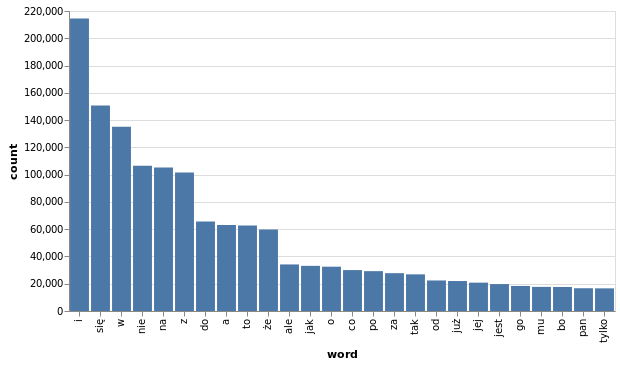

In [64]:
alt.Chart(df_for_vis).mark_bar().encode(
    x=alt.X('word', sort=alt.EncodingSortField(field='word', op='count', order='ascending')),
    y='count'
)

Dokonam dokładniejszych testów pozwalających określić czy uzyskane zliczenia słów mają rozkład Zipfa. Zaczynam od zaaplikowania logarytmu do rangi oraz zliczeń tym razem na pełnych danych:

In [65]:
df['rank'] = df.index + 1

In [66]:
df['log_count'] = np.log(df['count'])
df['log_rank'] = np.log(df['rank'])

In [67]:
df.head()

,word,count,rank,log_count,log_rank
0,i,214558,1,12.276335,0.000000
1,się,150620,2,11.922515,0.693147
2,w,135190,3,11.814436,1.098612
3,nie,106474,4,11.575656,1.386294
4,na,105147,5,11.563115,1.609438


Ze względu na duży rozmiar pliku, na którego podstawie zostanie zrenderowany wykres (Altair trzyma wykresy jako JSON) zapisuję wykres do oddzielnego pliku:

In [68]:
alt.data_transformers.enable('json')

altair_data_dir='altair_graphs'

def json_dir(data, data_dir=altair_data_dir):
    os.makedirs(data_dir, exist_ok=True)
    return alt.pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )


alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir', data_dir='altair_graphs')

DataTransformerRegistry.enable('json_dir')

Wykres (interaktywny) dla wszystkich punktów pokazuje raczej prostą linię:

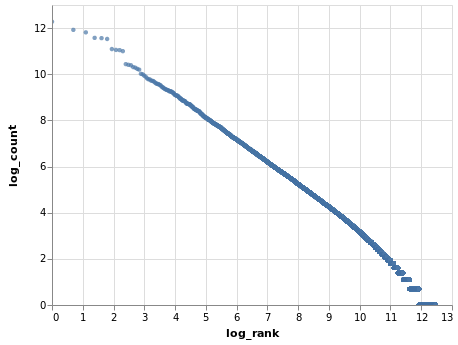

In [69]:
alt.Chart(df).mark_circle(size=20).encode(
    x='log_rank',
    y='log_count',
    tooltip=['word', 'count']
).interactive()

## n-gramy

Sprawdzam najczęstsze 2-gramy i 3-gramy dla analizowanego korpusu. Plik ładuje się jako lista linii. W utworach zdarza się, że zdania są oddzielone od siebie linią. W takich przypadkach można bezpiecznie założyć, że kolejne dwa zdania w oryginale występują tuż po sobie i składanie n-gramu z ostatnich elementów pierwszego zdania (*Rodowici Egipcjanie...*) z pierwszymi elementami kolejnego zdania (*Z biegiem czasu...*) ma sens.

In [71]:
[" ".join(clean_line(line)) for line in load_file('./data/pozytywizm/prus/faraon.txt')[240:245]] #używam czyszczenia, bo Faraon był konwertowany z .mobi do .txt

['',
 'rodowici egipcjanie mieli barwę skóry miedzianą czym chełpili się gardząc jednocześnie czarnymi etiopami żółtymi semitami i białymi europejczykami ten kolor skóry pozwalający odróżnić swojego od obcego przyczyniał się do utrzymania narodowej jedności silniej aniżeli religia którą można przyjąć albo język którego można się wyuczyć',
 '',
 'z biegiem czasu jednak kiedy państwowy gmach zaczął pękać do kraju coraz liczniej napływały obce pierwiastki osłabiały one spójność rozsadzały społeczeństwo a nareszcie zalały i rozpuściły w sobie pierwotnych mieszkańców kraju',
 '']

W innych przypadkach zależność ciągu myślowego nie jest taka jasna, np.:

In [72]:
load_file('./data/pozytywizm/orzeszkowa/gloria-victis-dziwna-historia.txt')[546:555]

['I oto jak spotkaliśmy się po raz ostatni.\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '\n',
 'Umilkła. W głębi pokoju, dotykane dalekim światłem lampy, mętnie majaczą iskry pozłot na książkach i zarysy obrazów na ścianach. Za oknami stoi bezoka noc listopadowa i w czarnym łonie toczy westchnienia coraz głębsze, coraz głuchsze, coraz dalsze…\n',
 '\n',
 '\n']

W jeszcze innym przypadku n-gramy nie powinny być tworzone na bazie ostatnich słów zdania poprzedniego i pierwszych słów zdania następnego:

In [73]:
[" ".join(clean_line(line)) for line in load_file('./data/henryk_sienkiewicz/potop.txt')[5015:5026]] #używam czyszczenia, bo Potop był konwertowany z .mobi do .txt

['jakże nie wiem odparł szlachcic to pan tomasz billewicz miecznik rosieński wszyscy go tu znają bo to dawny radziwiłłowski sługa i przyjaciel',
 '',
 '',
 '',
 '',
 '',
 'rozdział xiii',
 '',
 '',
 'książę nie pokazał się tego dnia szlachcie aż do wieczora obiadował bowiem z posłami i kilku dygnitarzami z którymi poprzednio naradę był składał przyszły jednak rozkazy do pułkowników żeby nadworne pułki radziwiłłowskie a zwłaszcza regimenty piechoty pod cudzoziemskimi oficerami stały w pogotowiu w powietrzu pachniało prochem zamek lubo nieobronny otoczony był wojskiem jak gdyby pod jego murami miano bitwę stoczyć spodziewano się pochodu najpóźniej na jutrzejszy ranek i były tego widome oznaki niezliczona bowiem czeladź książęca zajęta była ładowaniem na wozy broni kosztownych sprzętów i książęcego skarbca',
 '']

Słowo 'rozdział' występuje na tyle mało razy, że nie powinno zaburzyć n-gramów:

In [74]:
vocabulary_count['rozdział']/sum(vocabulary_count.values())

0.00015214221859773547

Dla każdego pliku łączę całą zawartość w jeden napis i na jego podstawie tworzę n-gramy. Przykładowo:

In [75]:
" ".join([word for word in ['test1', '', '', '', 'test2'] if word])

'test1 test2'

Zaczynam od małego pliku:

In [76]:
! find ./data/henryk_sienkiewicz/ -type f -name '*.txt' | xargs du -h | sort -h | head -n 5

4,0K	./data/henryk_sienkiewicz/sienkiewicz-bajka.txt
4,0K	./data/henryk_sienkiewicz/sienkiewicz-czy-ci-najmilszy.txt
4,0K	./data/henryk_sienkiewicz/sienkiewicz-hkt.txt
4,0K	./data/henryk_sienkiewicz/sienkiewicz-przygoda-arystoklesa.txt
4,0K	./data/henryk_sienkiewicz/sienkiewicz-sabalowa-bajka.txt


In [77]:
def generate_ngrams(file, n):
    # get a list of consecutive words
    tokens = list(chain(*[clean_line(line) for line in load_file(file)]))
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [tuple(ngram) for ngram in ngrams]

In [78]:
bigrams_example = generate_ngrams("./data/henryk_sienkiewicz/sienkiewicz-bajka.txt", 2)

In [79]:
bigrams_example[:10]

[('henryk', 'sienkiewicz'),
 ('sienkiewicz', 'bajka'),
 ('bajka', 'za'),
 ('za', 'górami'),
 ('górami', 'za'),
 ('za', 'morzami'),
 ('morzami', 'w'),
 ('w', 'dalekiej'),
 ('dalekiej', 'krainie'),
 ('krainie', 'czarów')]

In [80]:
cnt = Counter(bigrams_example)

In [81]:
cnt.most_common(10)

[(('dam', 'ci'), 3),
 (('bez', 'dobroci'), 3),
 (('dobroci', 'jest'), 3),
 (('na', 'to'), 2),
 (('się', 'nad'), 2),
 (('wasze', 'dary'), 2),
 (('henryk', 'sienkiewicz'), 1),
 (('sienkiewicz', 'bajka'), 1),
 (('bajka', 'za'), 1),
 (('za', 'górami'), 1)]

Dla każdego z autorów będę analizował n-gramy (aż do 3-gramów). Spodziewam się, że 1-gramy będą podobne (zdominowane przez partykuły, przyimki, spójniki). Wszystkie n-gramy będą trzymane w `big_n_gram_dict`.

In [82]:
max_n_gram = 3

In [83]:
# handle Sienkiewicz's case separately
big_n_gram_dict = dict()
big_n_gram_dict['sienkiewicz'] = dict()

# initialize big_n_gram_dict with names
for directory in os.listdir('./data/pozytywizm/'):
    big_n_gram_dict[directory] = dict()

for filename in os.listdir('./data/henryk_sienkiewicz/'):
    file_path = os.path.join('./data/henryk_sienkiewicz/', filename)
    for n in range(1, max_n_gram+1):
        try:
            big_n_gram_dict['sienkiewicz']["{}_gram".format(n)].update(Counter(generate_ngrams(file_path, n)))
        except KeyError:
            # handle the case in which the counter has not been initialised
            big_n_gram_dict['sienkiewicz']["{}_gram".format(n)] = Counter(generate_ngrams(file_path, n))

In [84]:
for directory in os.listdir('./data/pozytywizm/'):
    subdir = os.path.join('./data/pozytywizm/', directory)
    for filename in os.listdir(subdir):
        file_path = os.path.join(subdir, filename)
        for n in range(1, max_n_gram+1):
            try:
                big_n_gram_dict[directory]["{}_gram".format(n)].update(Counter(generate_ngrams(file_path, n)))
            except KeyError:
                big_n_gram_dict[directory]["{}_gram".format(n)] = Counter(generate_ngrams(file_path, n))   

Sprawdzam najczęstsze słowa (unigramy) dla każdego z twórców i potwierdzam swoje przypuszczenia:

In [85]:
for writer in ['sienkiewicz'] + [directory for directory in os.listdir("./data/pozytywizm/")]:
    print(writer.capitalize())
    print(big_n_gram_dict[writer]['1_gram'].most_common(10))
    print()

Sienkiewicz
[(('i',), 73946), (('się',), 52173), (('w',), 45038), (('nie',), 41036), (('na',), 36392), (('z',), 33930), (('że',), 25068), (('to',), 24195), (('do',), 22870), (('a',), 22041)]

Reymont
[(('i',), 29380), (('się',), 22487), (('nie',), 14003), (('w',), 13758), (('na',), 13428), (('z',), 12117), (('a',), 11032), (('to',), 9881), (('do',), 8624), (('że',), 7680)]

Konopnicka
[(('i',), 552), (('w',), 516), (('się',), 483), (('na',), 421), (('a',), 404), (('nie',), 357), (('z',), 331), (('to',), 291), (('jak',), 246), (('do',), 212)]

Prus
[(('i',), 29038), (('się',), 26215), (('w',), 19589), (('nie',), 18922), (('na',), 17356), (('z',), 14884), (('że',), 11668), (('do',), 11571), (('a',), 10929), (('to',), 8851)]

Zeromski
[(('i',), 24556), (('w',), 23065), (('się',), 17777), (('na',), 14639), (('z',), 14349), (('nie',), 10604), (('do',), 8493), (('to',), 7159), (('a',), 5789), (('jak',), 5130)]

Balucki
[(('i',), 2605), (('się',), 2431), (('w',), 1566), (('nie',), 1526), (('n

Sprawdzam 2-gramy. Ciekawe jest to, że w 2-gramach dla Sienkiewicza i Reymonta zawarte są informacje o przypisach, np *2509. zo­sta­wu­jem — dziś popr. for­ma 1.os. lm cz.ter.: zo­sta­wia­my. [przypis edytorski]* Sam Potop ma ich 2514:

In [86]:
for writer in ['sienkiewicz'] + [directory for directory in os.listdir("./data/pozytywizm/")]:
    print(writer.capitalize())
    print(big_n_gram_dict[writer]['2_gram'].most_common(10))
    print()

Sienkiewicz
[(('przypis', 'edytorski'), 5973), (('przypis', 'redakcyjny'), 3730), (('się', 'w'), 3010), (('się', 'z'), 2472), (('się', 'na'), 2390), (('się', 'do'), 2176), (('i', 'nie'), 1664), (('i', 'w'), 1565), (('się', 'i'), 1384), (('mu', 'się'), 1367)]

Reymont
[(('przypis', 'edytorski'), 3553), (('się', 'z'), 1081), (('się', 'w'), 1030), (('się', 'na'), 823), (('się', 'do'), 789), (('i', 'z'), 626), (('się', 'nie'), 616), (('i', 'nie'), 587), (('i', 'tak'), 560), (('daw', 'gw'), 543)]

Konopnicka
[(('i', 'na'), 24), (('a', 'to'), 24), (('się', 'z'), 21), (('jak', 'się'), 20), (('a', 'ty'), 20), (('der', 'der'), 20), (('pan', 'łukasz'), 19), (('raz', 'dwa'), 17), (('dwa', 'trzy'), 17), (('a', 'ja'), 16)]

Prus
[(('się', 'z'), 1513), (('się', 'w'), 1485), (('się', 'do'), 1364), (('się', 'na'), 1337), (('się', 'że'), 1054), (('przypis', 'redakcyjny'), 912), (('się', 'i'), 888), (('w', 'tej'), 815), (('pani', 'latter'), 708), (('mu', 'się'), 668)]

Zeromski
[(('się', 'w'), 1698), ((

Przypisy edytorskie i redakcyjne odciskają piętno także na 3-gramach. Warto zwrócić uwagę na *w tej chwili* oraz *w ten sposób*:

In [87]:
for writer in ['sienkiewicz'] + [directory for directory in os.listdir("./data/pozytywizm/")]:
    print(writer.capitalize())
    print(big_n_gram_dict[writer]['3_gram'].most_common(10))
    print()

Sienkiewicz
[(('w', 'tej', 'chwili'), 723), (('zwrócił', 'się', 'do'), 320), (('w', 'ten', 'sposób'), 292), (('się', 'z', 'nim'), 232), (('dziś', 'popr', 'forma'), 224), (('w', 'takim', 'razie'), 216), (('wasza', 'książęca', 'mość'), 215), (('nie', 'może', 'być'), 214), (('ok', 'km', 'na'), 214), (('od', 'czasu', 'do'), 203)]

Reymont
[(('przypis', 'edytorski', 'kiej'), 218), (('edytorski', 'kiej', 'gw'), 206), (('tylko', 'przypis', 'edytorski'), 175), (('gw', 'tylko', 'przypis'), 173), (('przypis', 'edytorski', 'jeno'), 170), (('jeno', 'daw', 'gw'), 160), (('edytorski', 'jeno', 'daw'), 159), (('daw', 'gw', 'tylko'), 159), (('jak', 'przypis', 'edytorski'), 156), (('aż', 'przypis', 'edytorski'), 131)]

Konopnicka
[(('raz', 'dwa', 'trzy'), 17), (('der', 'der', 'der'), 16), (('kle', 'kle', 'kle'), 12), (('wielki', 'pustak', 'nasza'), 9), (('pustak', 'nasza', 'hania'), 9), (('la', 'la', 'la'), 8), (('pi', 'pi', 'pi'), 8), (('raz', 'i', 'drugi'), 7), (('nasza', 'zima', 'zła'), 6), (('a', 'g

Co jeżeli wykluczę przypisy i partykuły? Poniższy przykład bardzo dobrze ilustruje jak bardzo stopwords mogą zanieczyścić listę n-gramów. Na 100 pierwszych 2-gramów jedynie mała część pozostaje po wyeliminowaniu tych, w której występuje co najmniej jeden stopword (`zakazane_slowa`):

In [88]:
zakazane_slowa = set(['przypis', 'redakcyjny', 'edytorski', 'w', 'z', 'i', 'o', 'nie', 'się', 'do', 'że', 'to', 'po', 'a', 'dla', 'tak', 'na'])

In [89]:
[n_gram for n_gram in big_n_gram_dict['sienkiewicz']['2_gram'].most_common(100) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('pan', 'zagłoba'), 816),
 (('tej', 'chwili'), 775),
 (('dziś', 'popr'), 535),
 (('przy', 'tym'), 474),
 (('pan', 'wołodyjowski'), 471),
 (('może', 'być'), 469)]

Podobny zabieg, ale zastosowany do 3-gramów pokazuje, że dane nie zostały do końca dobrze wyczyszczone, ponieważ częstymi trzygramami są słowa odnoszące się do licencji:

In [90]:
[n_gram for n_gram in big_n_gram_dict['sienkiewicz']['3_gram'].most_common(100) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('dziś', 'popr', 'forma'), 224),
 (('wasza', 'książęca', 'mość'), 215),
 (('przez', 'ten', 'czas'), 109),
 (('nastała', 'chwila', 'milczenia'), 109),
 (('waszej', 'książęcej', 'mości'), 101),
 (('rezydencja', 'książąt', 'wiśniowieckich'), 90),
 (('ukrainy', 'ok', 'km'), 89),
 (('jak', 'mi', 'bóg'), 87),
 (('mi', 'bóg', 'miły'), 86),
 (('części', 'ukrainy', 'ok'), 84),
 (('wielki', 'książę', 'litewski'), 82),
 (('śrwsch', 'ukrainie', 'rezydencja'), 79),
 (('ukrainie', 'rezydencja', 'książąt'), 79),
 (('jeno', 'daw', 'tylko'), 77),
 (('tekst', 'jest', 'własnością'), 77),
 (('jest', 'własnością', 'publiczną'), 77),
 (('własnością', 'publiczną', 'public'), 77),
 (('publiczną', 'public', 'domain'), 77),
 (('public', 'domain', 'szczegóły'), 77),
 (('domain', 'szczegóły', 'licencji'), 77)]

Widzimy, że w 2-gramach i 3-gramach bez udziału stopwords mamy do czynienia także z informacjami przypisowymi (daw jako dawniej, gw jako gwarowo):

In [91]:
[n_gram for n_gram in big_n_gram_dict['reymont']['2_gram'].most_common(100) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('daw', 'gw'), 543),
 (('co', 'chwila'), 217),
 (('za', 'nim'), 217),
 (('kiej', 'gw'), 206),
 (('gw', 'tylko'), 183),
 (('za', 'nią'), 160),
 (('jeno', 'daw'), 160)]

In [92]:
[n_gram for n_gram in big_n_gram_dict['reymont']['3_gram'].most_common(100) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('jeno', 'daw', 'gw'), 160),
 (('daw', 'gw', 'tylko'), 159),
 (('jaże', 'gw', 'aż'), 127),
 (('kiej', 'gw', 'jak'), 118),
 (('kieby', 'gw', 'niby'), 65),
 (('kajś', 'gw', 'gdzieś'), 63),
 (('kiej', 'gw', 'kiedy'), 61),
 (('gw', 'niby', 'jak'), 59),
 (('ze', 'wszystkich', 'stron'), 58),
 (('cosik', 'gw', 'coś'), 58),
 (('kaj', 'gw', 'gdzie'), 55),
 (('me', 'gw', 'mnie'), 54),
 (('boga', 'tego', 'kocham'), 51),
 (('jak', 'boga', 'tego'), 49),
 (('cięgiem', 'gw', 'ciągle'), 40),
 (('jąć', 'daw', 'gw'), 39),
 (('daw', 'gw', 'zacząć'), 39),
 (('se', 'gw', 'sobie'), 38),
 (('ha', 'ha', 'ha'), 36)]

Do stopwords dodaję wyjątki dla informacji przypisowych:

In [93]:
zakazane_slowa = zakazane_slowa.union(set(['gw', 'daw']))

Dla Reymonta widzimy akcję umiejscowioną na wsi (bigram *we wsi*):

In [94]:
[n_gram for n_gram in big_n_gram_dict['reymont']['2_gram'].most_common(200) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('co', 'chwila'), 217),
 (('za', 'nim'), 217),
 (('za', 'nią'), 160),
 (('pan', 'jezus'), 138),
 (('ale', 'już'), 129),
 (('bo', 'już'), 117),
 (('we', 'wsi'), 115),
 (('przy', 'tym'), 115),
 (('ze', 'wszystkich'), 113),
 (('tej', 'chwili'), 104),
 (('u', 'nas'), 104),
 (('przed', 'nim'), 95)]

oraz religijność bohaterów:

In [95]:
[n_gram for n_gram in big_n_gram_dict['reymont']['3_gram'].most_common(200) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('ze', 'wszystkich', 'stron'), 58),
 (('boga', 'tego', 'kocham'), 51),
 (('jak', 'boga', 'tego'), 49),
 (('ha', 'ha', 'ha'), 36),
 (('psiakość', 'nóżki', 'baranie'), 30),
 (('dobrodzieju', 'mój', 'kochany'), 26),
 (('jak', 'ten', 'pies'), 23)]

In [96]:
zakazane_slowa = zakazane_slowa.union(set(['kto', 'przez', 'co']))

U Orzeszkowej także widać religijność bohaterów:

In [97]:
[n_gram for n_gram in big_n_gram_dict['orzeszkowa']['2_gram'].most_common(200) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('tej', 'chwili'), 302),
 (('widać', 'było'), 202),
 (('przed', 'nim'), 177),
 (('pan', 'bóg'), 175),
 (('tu', 'robić'), 174),
 (('ku', 'niemu'), 173),
 (('tym', 'razem'), 170),
 (('za', 'nią'), 166),
 (('można', 'było'), 163),
 (('przed', 'nią'), 161),
 (('raz', 'pierwszy'), 143),
 (('może', 'być'), 142)]

In [98]:
[n_gram for n_gram in big_n_gram_dict['orzeszkowa']['3_gram'].most_common(200) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('cha', 'cha', 'cha'), 75),
 (('ach', 'ach', 'ach'), 45),
 (('jak', 'boga', 'kocham'), 44),
 (('czy', 'ja', 'wiem'), 36),
 (('tej', 'samej', 'chwili'), 35),
 (('panie', 'mój', 'kochany'), 33),
 (('pod', 'tym', 'względem'), 31),
 (('od', 'tego', 'czasu'), 23),
 (('poznać', 'można', 'było'), 22),
 (('boże', 'mój', 'boże'), 21),
 (('kilka', 'kroków', 'od'), 21),
 (('ha', 'ha', 'ha'), 21)]

U Prusa zauważalni są nazwami bohaterowie: *Panna Latter* (Emancypatka), *Panna Izabela*/*Panny Izabeli* (Lalka), *Panna Howard* (Emancypatka), *Pan Tomasz* (Katarynka):

In [99]:
[n_gram for n_gram in big_n_gram_dict['prus']['2_gram'].most_common(200) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('pani', 'latter'), 708),
 (('tej', 'chwili'), 645),
 (('panna', 'izabela'), 452),
 (('pan', 'kazimierz'), 252),
 (('tysięcy', 'rubli'), 249),
 (('panna', 'howard'), 230),
 (('pan', 'ignacy'), 197),
 (('może', 'być'), 190),
 (('u', 'nas'), 189),
 (('za', 'rękę'), 187),
 (('ze', 'mną'), 184),
 (('zdawało', 'mu'), 171),
 (('pan', 'tomasz'), 162),
 (('nade', 'wszystko'), 160),
 (('go', 'za'), 159),
 (('przede', 'wszystkim'), 154),
 (('musi', 'być'), 150),
 (('za', 'nim'), 148),
 (('zdaje', 'mi'), 148),
 (('od', 'tej'), 143),
 (('ale', 'ja'), 142),
 (('kilka', 'dni'), 139),
 (('od', 'razu'), 138),
 (('wasza', 'dostojność'), 136),
 (('takim', 'razie'), 135),
 (('panny', 'izabeli'), 133),
 (('jego', 'świątobliwości'), 133),
 (('można', 'było'), 131),
 (('przy', 'tym'), 129)]

Miejsce akcji Faraona (*Dolny Egipt*), który był podzielony na 20 *nomów*([nomy](https://pl.wikipedia.org/wiki/Dolny_Egipt#/media/File:GD-EG-Nomes_de_Basse-%C3%89gypte.jpg)) oraz jednostka monetarna zaboru rosyjskiego (rubel):

In [100]:
[n_gram for n_gram in big_n_gram_dict['prus']['3_gram'].most_common(200) if not set(n_gram[0]).intersection(zakazane_slowa)]

[(('od', 'tej', 'pory'), 93),
 (('go', 'za', 'rękę'), 55),
 (('ją', 'za', 'rękę'), 54),
 (('czy', 'ja', 'wiem'), 50),
 (('cha', 'cha', 'cha'), 41),
 (('ze', 'wszystkich', 'stron'), 38),
 (('od', 'kilku', 'dni'), 33),
 (('od', 'tej', 'chwili'), 29),
 (('oby', 'żył', 'wiecznie'), 27),
 (('cztery', 'tysiące', 'rubli'), 24),
 (('od', 'pewnego', 'czasu'), 24),
 (('dziesięć', 'tysięcy', 'rubli'), 24),
 (('trzydzieści', 'tysięcy', 'rubli'), 23),
 (('nomu', 'dolnego', 'egiptu'), 23),
 (('tej', 'samej', 'chwili'), 22)]

## word2vec

W poniższej części zajmuję się tworzeniem reprezentacji wektorowych słów w analizowym korpusie.

Celem zwiększenia szybkości wykonywanych obliczeń stosuję:

In [235]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [6]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Tworzę listę list, gdzie zagnieżdżona lista zawiera słowa składające się na poszczególne zdania:

In [101]:
sentences_toy_data = [clean_line(line) for line in load_file('./data/henryk_sienkiewicz/potop.txt')[5015:5026] if line != '\n']

In [102]:
sentences_toy_data[0]

['jakże',
 'nie',
 'wiem',
 'odparł',
 'szlachcic',
 'to',
 'pan',
 'tomasz',
 'billewicz',
 'miecznik',
 'rosieński',
 'wszyscy',
 'go',
 'tu',
 'znają',
 'bo',
 'to',
 'dawny',
 'radziwiłłowski',
 'sługa',
 'i',
 'przyjaciel']

In [103]:
sentences = []

In [104]:
for filename in os.listdir('./data/henryk_sienkiewicz/'):
    file_path = os.path.join('./data/henryk_sienkiewicz/', filename)
    sentences += [clean_line(line) for line in load_file(file_path) if line != '\n']

In [105]:
for directory in os.listdir('./data/pozytywizm/'):
    subdir = os.path.join('./data/pozytywizm/', directory)
    for filename in os.listdir(subdir):
        file_path = os.path.join(subdir, filename)
        sentences += [clean_line(line) for line in load_file(file_path) if line != '\n']

In [106]:
len(sentences)

236529

Definiuję parametry modelu:
 - `min_count`: ignoruje słowa, które występują rzadziej niż zadana liczba razy
 - `window`: jaka odległość w zdaniu dzieli obecnie analizowane słowo (input do sieci) od przewidywanego (output z sieci)
 - `size`: wymiar wektora zanurzonego
 - `workers`: liczba rdzeni do obsługi trenowania modelu
 - `seed`: ziarno, które zapewnia replikowalność

In [328]:
w2v_pozytywizm = Word2Vec(sentences, size=100, window=5, min_count=5, workers=cores-2, seed=123)

INFO - 18:45:46: collecting all words and their counts
INFO - 18:45:46: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:45:46: PROGRESS: at sentence #10000, processed 310875 words, keeping 40921 word types
INFO - 18:45:46: PROGRESS: at sentence #20000, processed 565984 words, keeping 58780 word types
INFO - 18:45:46: PROGRESS: at sentence #30000, processed 911598 words, keeping 77806 word types
INFO - 18:45:46: PROGRESS: at sentence #40000, processed 1238606 words, keeping 93103 word types
INFO - 18:45:46: PROGRESS: at sentence #50000, processed 1528328 words, keeping 105237 word types
INFO - 18:45:46: PROGRESS: at sentence #60000, processed 1764294 words, keeping 112687 word types
INFO - 18:45:46: PROGRESS: at sentence #70000, processed 1980724 words, keeping 120420 word types
INFO - 18:45:46: PROGRESS: at sentence #80000, processed 2248307 words, keeping 132726 word types
INFO - 18:45:46: PROGRESS: at sentence #90000, processed 2494371 words, keeping 14439

In [329]:
w2v_pozytywizm.train(sentences, total_examples=len(sentences), epochs=100)

WARNING - 18:48:24: Effective 'alpha' higher than previous training cycles
INFO - 18:48:24: training model with 6 workers on 76645 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 18:48:25: EPOCH 1 - PROGRESS: at 25.45% examples, 1422472 words/s, in_qsize 9, out_qsize 2
INFO - 18:48:26: EPOCH 1 - PROGRESS: at 60.01% examples, 1400295 words/s, in_qsize 9, out_qsize 2
INFO - 18:48:27: EPOCH 1 - PROGRESS: at 91.17% examples, 1385729 words/s, in_qsize 11, out_qsize 0
INFO - 18:48:27: worker thread finished; awaiting finish of 5 more threads
INFO - 18:48:27: worker thread finished; awaiting finish of 4 more threads
INFO - 18:48:27: worker thread finished; awaiting finish of 3 more threads
INFO - 18:48:27: worker thread finished; awaiting finish of 2 more threads
INFO - 18:48:27: worker thread finished; awaiting finish of 1 more threads
INFO - 18:48:27: worker thread finished; awaiting finish of 0 more threads
INFO - 18:48:27: EPOCH - 1 : training on 58760

(468066948, 587608100)

Zapisuję model, aby później nie musieć go ponownie estymować:

In [345]:
w2v_pozytywizm.wv.save_word2vec_format('w2v_pozytywizm_full_forms.bin', binary=True)

INFO - 19:01:37: storing 76645x100 projection weights into w2v_pozytywizm_full_forms.bin
WARNING - 19:01:37: this function is deprecated, use smart_open.open instead


Załadowanie modelu:

In [8]:
w2v_pozytywizm_from_bin = KeyedVectors.load_word2vec_format("w2v_pozytywizm_full_forms.bin", binary=True)

W przeciwieństwie do języka angielskiego język polski ma bogatą fleksję, a co za tym idzie mnogość form, w których wyrazy mogą występować. Poniżej sprawdzam czy pary podobnych wyrazów (w mianowniku) zachowują się tak samo w innych przypadkach. 'kobieta' w mianowniku jest podobna do innych słów niż 'kobieta' w liczbie mnogiej w mianowniku:

In [27]:
w2v_pozytywizm_from_bin.most_similar('kobieta')

[('dziewczyna', 0.8108365535736084),
 ('dama', 0.7211305499076843),
 ('osoba', 0.6993241310119629),
 ('ona', 0.6743534207344055),
 ('kobiecina', 0.6726367473602295),
 ('panienka', 0.6462386250495911),
 ('niewiasta', 0.64083331823349),
 ('istota', 0.6300680041313171),
 ('staruszka', 0.6248067021369934),
 ('matka', 0.6160675883293152)]

In [29]:
w2v_pozytywizm_from_bin.most_similar('kobietom')

[('ludziom', 0.6518710851669312),
 ('mężczyznom', 0.5133285522460938),
 ('im', 0.49633872509002686),
 ('dzieciom', 0.4645894169807434),
 ('narodom', 0.4531635642051697),
 ('dostępnych', 0.43775635957717896),
 ('niewiastom', 0.4182112514972687),
 ('nam', 0.4173569977283478),
 ('niedostateczne', 0.41671890020370483),
 ('mężowi', 0.4144447445869446)]

In [34]:
w2v_pozytywizm_from_bin.most_similar('kobietom')

[('ludziom', 0.8259347677230835),
 ('mężczyznom', 0.7566635608673096),
 ('im', 0.7481686472892761),
 ('dzieciom', 0.732293963432312),
 ('narodom', 0.7265810966491699),
 ('dostępnych', 0.7188774347305298),
 ('niewiastom', 0.7091049551963806),
 ('nam', 0.7086778283119202),
 ('niedostateczne', 0.7083588242530823),
 ('mężowi', 0.7072216868400574)]